# Deployment of neural networks

In de vorige weken heb je geleerd hoe je neurale netwerken kan aanmaken, trainen en evalueren.
Wanneer je een goed werkend model hebt wil je dit vaak in de praktijk gebruiken/ in productie brengen.
Deze stap wordt typisch deployment van een model genoemd. 

Er zijn verscheidene manieren om een model te deployen:
* Remote
* On-Device

## Remote access

Een eerste manier om een model te gebruiken in een applicatie is door het model op een server te plaatsen.
Dit kan op door onder andere gebruik te maken van een bestaande cloud-service (Azure, AWS, Firebase, ...) of op een eigen server te plaatsen.
In beide gevallen wordt er dan een request gestuurd naar de server gestuurd met de input voor het model.
De server voert dan het model uit en met de gegeven input en stuurt het antwoord terug.

Deze techniek wordt vaak gebruikt voor complexe modellen die te zwaar zouden zijn om uit te voeren op de meeste devices waarvoor het bedoeld is (robots/smartphones/...).
Ook is je model beschermd tegen misbruik omdat de verschillende gebruikers geen toegang hebben tot de structuur van het model en de gewichten.
Hierdoor kan je gemakkelijker het aantal voorspellingen controleren van een gebruiker en hiervoor de nodige kosten aanrekenen.

Echter zijn er ook nadelen verbonden met deze techniek. Het grootste nadeel is dat er steeds een netwerkverbinding moet zijn voor het model te laten werken.
Hierdoor is het niet altijd bruikbaar om een remote model te gebruiken.
Door de netwerk communicatie kan het ook langer duren voor een voorspelling uitgevoerd is (vooral voor kleinere modellen).

## On-Device

Door de opkomst van neurale netwerken in allerhande toepassingen is er ook een nood aan de netwerken te gebruiken in verschillende talen.
Tensorflow is geschreven in de programmeertaal C om performantieredenen en kan daardoor eenvoudig gebruikt worden allerhande packages.
Hierdoor zijn er allerlei packages/libraries ontwikkeld in allerhande talen om met ML aan de slag te gaan.
Zo is er:
* Tensorflow.net in C#
* Een interface om tensorflow code aan te spreken met Java
* Tensorflow lite voor bvb kotlin om op android te developpen

De voordelen bij het gebruiken van een on-device toepassing is dat je steeds gebruik kunt maken van het model, ook zonder netwerk verbinding.
Dit kan belangrijk zijn bij real-time applicaties.
Het belangrijkste nadeel is dat de complexiteit van het model beperkt is door de beperkingen van het (zwakste) toestel waarop de applicatie moet werken.

## Firebase

Een cloud-service die onder andere gebruikt kan worden als NoSQL database voor je applicaties.
Ook kan firebase gebruikt worden voor de volgende zaken:
* Bijhouden van je modellen
* Mogelijkheid om updates van je model te verspreiden naar alle devices die er nood aan hebben
* Bijhouden van logs om verdere training/optimalisatie uit te voeren
* Uitvoeren van voorspellingen

Volg eerst de stappen op [deze pagina](https://firebase.google.com/docs/ml/manage-hosted-models) om een firebase project aan te maken via de Firebase Admin SDK dat we gaan gebruiken in de loop van deze notebook.

In de code hieronder gaan we werken met een bestaand ML-model dat bewaard is in de **model.keras file**.
Dit model is getrained op de MNIST dataset om handgeschreven cijfers te herkennen)
Dit tensorflow model gaan we daarna omzetten naar een tensorflow-lite model (dit is het type waarmee firebase werkt en is een lightweight versie van het tensorflow model).
Dit tensorflowlite model kan geupload worden naar firestore. 
Volg hiervoor de tutorial verder om het model te plaatsen op de firestore.

In [ ]:
!pip install firebase_admin

In [1]:
# connect to firebase
import firebase_admin
from firebase_admin import ml
from firebase_admin import credentials
import tensorflow as tf

firebase_admin.initialize_app(
    credentials.Certificate("../../../../firebase_admin.json"),
    options={
        'storageBucket': 'ml-deployment-707dd.appspot.com'
    }
)

In [11]:
# download model and create new model

model =tf.keras.models.load_model('model.keras')

In [12]:
tmp = ml.TFLiteGCSModelSource.from_keras_model(model)

tflite_model = ml.TFLiteFormat(tmp)
model = ml.Model(
    display_name="Voorbeeld",
    tags=["Voorbeeld", "uit", "les"],
    model_format=tflite_model
)

firebase_model = ml.create_model(model)
ml.publish_model(firebase_model.model_id)

INFO:tensorflow:Assets written to: C:\Users\JENS~1.BAE\AppData\Local\Temp\tmpwr4i6c2l\assets


INFO:tensorflow:Assets written to: C:\Users\JENS~1.BAE\AppData\Local\Temp\tmpwr4i6c2l\assets


Onder de Machine Learning pagina op je project pagina van Firebase kan je verifieren of het uploaden van het model geslaagd is.
Indien je de informatie van het model later wil aanpassen of updaten kan je dat doen op de volgende manier

In [14]:
# add tags to the model
firebase_model.display_name = "Voorbeeld2"

updated_model = ml.update_model(firebase_model)
ml.publish_model(updated_model.model_id)

Nu kan dit model door je applicatie gedownload worden en het model gebruikt worden om voorspellingen te doen.
Schrijf in de cell hieronder de nodige code om dit uit te voeren en maak gebruik van de figuur **test.png** om te kijken of het model correct werkt.

In [22]:
# use the model

from fileinput import filename


iterator = ml.list_models().iterate_all()
filepath = ""
modelid = -1

for m  in iterator:
    fields = m.as_dict()
    print(fields)

    # laatste stuk achter de slides van de name
    model_id = fields["name"].split("/")[-1]
    print(model_id)

    # de gcsTfliteuri bestaat uit {storagebucket}/{path in storage bucket}
    filepath = fields["tfliteModel"]["gcsTfliteUri"].split("appspot.com/")[-1]

print(filepath)

bucket_name = "ml-deployment-707dd.appspot.com"

destination_file = "model_downloaded.keras"

bucket = firebase_admin.storage.bucket(bucket_name)

blob = bucket.blob(filepath)
blob.download_to_filename(destination_file)

{'name': 'projects/ml-deployment-707dd/models/20030888', 'displayName': 'Voorbeeld2', 'createTime': '2022-10-25T12:28:31.102905Z', 'updateTime': '2022-10-25T12:29:39.546239Z', 'state': {'published': True}, 'etag': '9062183a118e6fa6f5a3d5bed19f387d46565f9c36fd41c94ddaa56f4640e1ff', 'modelHash': '37c5c97709e5681490b56a250416e01065b9016c474a7b3464bb731d12909f0e', 'tags': ['Voorbeeld', 'les', 'uit'], 'tfliteModel': {'sizeBytes': '408808', 'gcsTfliteUri': 'gs://ml-deployment-707dd.appspot.com/Firebase/ML/Models/firebase_ml_model.tflite'}}
20030888
Firebase/ML/Models/firebase_ml_model.tflite


(10000, 28, 28)
<class 'numpy.ndarray'>


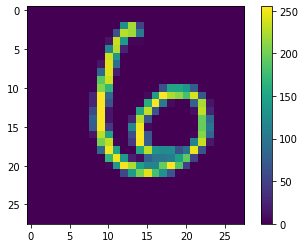

In [24]:
# show results
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

test_image=x_test[100].astype("float32")

print(x_test.shape)
plt.imshow(test_image)
plt.colorbar()

print(type(x_test[0]))

Buiten het model te downloaden en te gebruiken als een on-device model is het ook mogelijk om dit model uit te voeren in de cloud.
Dit kan je doen door een Get-request te sturen naar Firebase met de input.
Als response krijg je dan de output.
Echter moet hiervoor je account een upgrade hebben naar een betalende account.
Dit zou nog steeds gratis moeten zijn indien je binnen de grenzen blijft van het gratis plan maar indien er toch iets misgaat of je verkeerd doet gaan we dit niet doen.

## Azure

Natuurlijk is Firebase slechts 1 van de mogeljke cloud-services om te gebruiken.
Een andere mogelijkheid is om gebruik te maken van de **Azure** cloud omgeving.
Een tutorial bestaande uit 2 delen kan je hier vinden:
* [Deel 1](https://medium.com/@mostafa.m.ayoub/deploy-your-local-python-ml-project-to-azure-part-1-b8a98b6e574a): Opzetten van de omgeving
* [Deel 2](https://medium.com/@mostafa.m.ayoub/deploy-your-local-python-ml-project-to-azure-part-2-392ac4dbdd75): Deploy local ML to Azure

Eerst moeten we nog de nodige software installeren om python te kunnen gebruiken samen met azure:
* Installeren Acure CLI, zie [hier](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-cli?tabs=public)
* Installeren Azure ML SDK: v1 is tot python 3.9 ([link](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/install?view=azure-ml-py)) of v2 voor nieuwere python versies ([link](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/installv2?view=azure-ml-py))